
# **Welcome to the eWaterCycle expirement notebook**

This notebook was generated by the eWaterCycle experiment launcher.

We will use GRDC data for comparison between the model simulation and the observations.

In this example notebook we run a hydrology model using [grpc4bmi](https://github.com/eWaterCycle/grpc4bmi), but you can also choose to run your own model, WFLOW or Walrus.


In [103]:
%matplotlib inline  
import os

import cftime
import hydrostats.visual as hv
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr

from ewatercycle.parametersetdb import build_from_urls
from ewatercycle.observation.grdc import get_grdc_data
from grpc4bmi.bmi_client_docker import BmiClientDocker

## **Setting the input and output configuration**

In [3]:
parameter_set = build_from_urls(
    config_format='ini', config_url='https://raw.githubusercontent.com/UU-Hydro/PCR-GLOBWB_input_example/master/RhineMeuse30min/ini_and_batch_files/rapid/setup_natural_test.ini',
    datafiles_format='svn', datafiles_url='https://github.com/UU-Hydro/PCR-GLOBWB_input_example/trunk/RhineMeuse30min',
)
parameter_set.save_datafiles('./input')

The model inside a BMI Docker container expects the datafiles in the /data/input directory,
the config file must be adjusted to that. 
**Uncomment** the block of the model that you are using:

*Please note that creating the input/output folders should be done only once.*

 - For **PCR-GLOBWB** model the input and output directory must be set with:

In [4]:
parameter_set.config['globalOptions']['inputDir'] = '/data/input'
parameter_set.config['globalOptions']['outputDir'] = '/data/output'

- For **wflow** model the config file must be set with: 

In [5]:
#parameter_set.config['model']['configfile'] = '/data/input/wflow_sbm.ini'
#replace config.cfg in the next cells with wflow_sbm.ini

- For **Walrus** model the data file must be set with

In [6]:
#parameter_set.config['data'] = '/data/input/' + os.listdir('input')[0]

Then it can be saved to the config file:

In [7]:
parameter_set.save_config('config.cfg')

## **Run docker container that contains model**

In this example we use pcrglob, the model is loaded and initialized according to the configuration file we created in the previous section.

In [8]:
# Startup model
model = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:latest', image_port=55555,
                        input_dir="./input",
                        output_dir="./output")
model.initialize('config.cfg')

Gather information about the way the model handles time as this is needed to evolve the model:

In [24]:
tstart = int(model.get_start_time())
tend = int(model.get_end_time())
tstep = int(model.get_time_step())
tunit = model.get_time_units()
tstep_nmbr = (tend - tstart)/tstep 

print('model time step:', tstep)
print('model time unit:', tunit)
print('model time start:', tstart)
print('model time end:', tend)
print('nr of steps:', tstep_nmbr)

model time step: 1
model time unit: days since 1901-01-01
model time start: 36525
model time end: 40176
nr of steps: 3651.0


### Evolve the model and capture variable discharge

Select the variable of our choice and the index of the pixel to record. The pixel index should correspond to the location of the GRDC station that is used to compare the model with.

In [11]:
variable = 'discharge'
pixel_index = np.array([144])
variable_overtime = []

In [ ]:
while model.get_current_time() < tend:
    model.update()
    value_at_pixel = model.get_value_at_indices(variable, pixel_index)[0]
    variable_overtime.append((model.get_current_time(), value_at_pixel))

## **Visualizing the output**

### Plot the variable at the current time as a function of lon/lat

Get the variable values at the current time, coordinates and other useful information for this plot. Since the model just ran until `tend`, this the current time. 

In [30]:
vals = model.get_value(variable)
unit = model.get_var_units(variable)
shape = model.get_grid_shape(model.get_var_grid(variable))
lon = model.get_grid_x(0)
lat = model.get_grid_y(0)
current_date = cftime.num2date(model.get_current_time(),tunit).date()

Reshape the one dimensional list of values to a two dimensional array for plotting and make the plot

[]

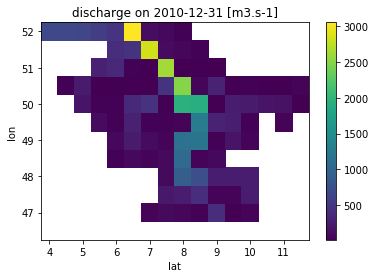

In [43]:
vals_array = np.reshape(ma.masked_where(vals == np.nan, vals), shape)
plt.title(r'{} on {} [{}]'.format(variable,current_date,unit))
plt.pcolormesh(lat,lon,vals_array)
plt.colorbar()
plt.xlabel('lat')
plt.ylabel('lon')
plt.plot()

## **Compare model with observations:**

### Adjust the start/end time of your model to GRDC data.
Each modeler will have to adjust to his/her own model. Here we adjust to pcrglob.

In [67]:
dstart = cftime.num2date(tstart, tunit).date()
dend = cftime.num2date(tend, tunit).date()
dlist = [cftime.num2date(d[0], tunit).date() for d in variable_overtime]

Convert the pcrglob data into dataframe format (required for hydrostat)

In [82]:
var_df = pd.DataFrame(variable_overtime, columns=["sim_time", "simulation"])
var_df = var_df.drop(columns=["sim_time"])
var_df.index = dlist
var_df.index.name = "date"

### Import GRDC data
Load the data using GRDC station id and the start and end date of the model run

In [100]:
station_id = '6335020' 
observations = get_grdc_data(station_id, str(dstart), str(dend))

In [101]:
obs_df = observations.to_dataframe()
var_df["observation"] = obs_df["streamflow"]

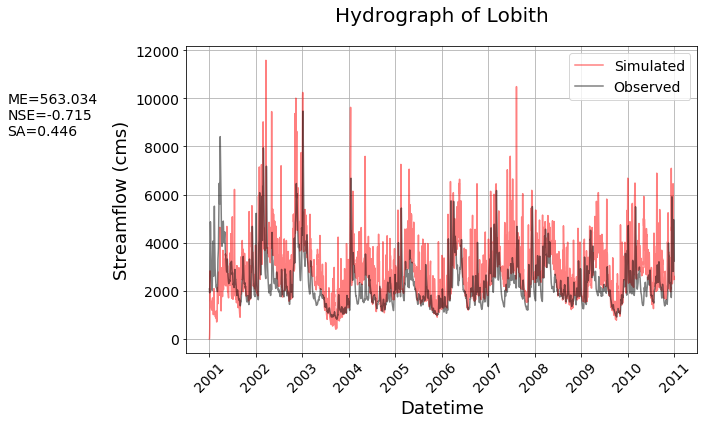

In [102]:
#Plot hydrograph for simulated and observed values and calculate statistics

hv.plot(var_df[['simulation', 'observation']],
      title='Hydrograph of Lobith',
      linestyles=['r-', 'k-'],
      legend=('Simulated', 'Observed'),
      labels=['Datetime', 'Streamflow (cms)'],
      metrics=['ME', 'NSE', 'SA'],
      grid=True)
plt.show()